# Single Input Multiple Output Anchor-Free Object Detection

Code is based off of ART-Net (https://github.com/kamruleee51/ART-Net).

In [1]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class ToolDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, max_bboxes=2):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.max_bboxes = max_bboxes
        self.image_files = [
            f
            for f in os.listdir(image_dir)
            if os.path.isfile(os.path.join(image_dir, f)) and not "Neg" in f and os.path.exists(os.path.join(label_dir, f.replace(".png", ".txt"))) and os.path.getsize(os.path.join(label_dir, f.replace(".png", ".txt")))>1
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace(".png", ".txt"))

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512, 512))  # Resize images to 512x512
        image = image / 255.0

        if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
            labels = np.loadtxt(label_path, delimiter=" ")
            if labels.ndim == 1:
                labels = labels[np.newaxis, :]
        else:
            labels = np.zeros((0, 5))  # No bounding boxes

        # Pad labels to fixed size
        if len(labels) > self.max_bboxes:
            labels = labels[: self.max_bboxes]
        else:
            padding = np.zeros((self.max_bboxes - len(labels), 5))
            labels = np.vstack((labels, padding))

        labels = torch.tensor(labels, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels


# Define transformations
transform = transforms.Compose([transforms.ToTensor()])

# Create datasets
train_dataset = ToolDataset(
    image_dir="data/ART-Net/images/train",
    label_dir="data/ART-Net/labels/train",
    transform=transform,
)
val_dataset = ToolDataset(
    image_dir="data/ART-Net/images/val",
    label_dir="data/ART-Net/labels/val",
    transform=transform,
)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Initially 1324 train and 308 val images before cleaning negative samples and those with missing bounding boxes.

In [2]:
print(len(train_dataset), len(val_dataset))

662 154


In [3]:
import certifi

os.environ["SSL_CERT_FILE"] = certifi.where()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import numpy as np
from collections import deque
from scipy.optimize import linear_sum_assignment


class SIMOModel(nn.Module):
    def __init__(self, n_classes=4):  # 4 outputs for bounding box coordinates
        super(SIMOModel, self).__init__()
        self.vgg_base = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features

        # Feature representation generator (FRG)
        self.frg = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        # Decoder for tool bounding box regression
        self.tool_decoder = nn.Sequential(
            nn.Conv2d(
                1024, 512, kernel_size=3, padding=1
            ),  # 1024 channels due to concatenation of VGG and FRG
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                128, n_classes, kernel_size=1
            ),  # 4 outputs for bounding box coordinates
            nn.AdaptiveAvgPool2d((1, 1)),  # Pooling to get a 1x1 output
            nn.Flatten(),  # Flatten to shape [batch_size, 4]
        )

        # Decoder for tooltip bounding box regression
        self.tooltip_decoder = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                128, n_classes, kernel_size=1
            ),  # 4 outputs for bounding box coordinates
            nn.AdaptiveAvgPool2d((1, 1)),  # Pooling to get a 1x1 output
            nn.Flatten(),  # Flatten to shape [batch_size, 4]
        )

        # Confidence prediction for tool
        self.tool_confidence = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 1, kernel_size=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Sigmoid(),  # Confidence between 0 and 1
        )

        # Confidence prediction for tooltip
        self.tooltip_confidence = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 1, kernel_size=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Sigmoid(),  # Confidence between 0 and 1
        )

    def forward(self, x):
        # VGG base layers
        block1_pool = self.vgg_base[:5](x)  # block1_pool
        block2_pool = self.vgg_base[5:10](block1_pool)  # block2_pool
        block3_pool = self.vgg_base[10:17](block2_pool)  # block3_pool
        block4_pool = self.vgg_base[17:24](block3_pool)  # block4_pool
        x_vgg = self.vgg_base[24:](block4_pool)  # block5_pool

        # Feature representation generator
        frg = self.frg(x)

        # Resize FRG output to match VGG output size
        frg_resized = F.interpolate(
            frg,
            size=(x_vgg.size(2), x_vgg.size(3)),
            mode="bilinear",
            align_corners=True,
        )

        # Concatenate VGG and FRG outputs for both tool and tooltip
        combined_features = torch.cat((x_vgg, frg_resized), dim=1)

        # Decoder for tool and tooltip
        tool_output = self.tool_decoder(combined_features)
        tooltip_output = self.tooltip_decoder(combined_features)

        # Confidence predictions
        tool_conf = self.tool_confidence(combined_features)
        tooltip_conf = self.tooltip_confidence(combined_features)

        return tool_output, tool_conf, tooltip_output, tooltip_conf

    def detect_objects(self, x):
        tool_boxes, tool_confs, tooltip_boxes, tooltip_confs = self.forward(x)

        # Filter out boxes with low confidence
        tool_indices = torch.where(tool_confs > 0.5)[0]
        tooltip_indices = torch.where(tooltip_confs > 0.5)[0]

        tool_boxes = tool_boxes[tool_indices]
        tool_confs = tool_confs[tool_indices]

        tooltip_boxes = tooltip_boxes[tooltip_indices]
        tooltip_confs = tooltip_confs[tooltip_indices]

        return tool_boxes, tool_confs, tooltip_boxes, tooltip_confs

    def track_objects(self, images):
        tracker = ObjectTracker()  # Instantiate the tracker

        for frame in images:
            tool_boxes, tool_confs, tooltip_boxes, tooltip_confs = self.detect_objects(
                frame
            )

            # Update tracker with detected boxes and confidences
            tracker.update(tool_boxes, tool_confs, tooltip_boxes, tooltip_confs)

        return tracker.get_tracks()  # Get the tracked object paths


class ObjectTracker:
    def __init__(self, max_age=30, min_hits=3, iou_threshold=0.3):
        self.max_age = max_age
        self.min_hits = min_hits
        self.iou_threshold = iou_threshold
        self.trackers = []
        self.frame_count = 0

    def iou(self, box1, box2):
        """Calculate the Intersection over Union (IoU) of two bounding boxes."""
        x1, y1, x2, y2 = box1
        x1g, y1g, x2g, y2g = box2

        xx1 = max(x1, x1g)
        yy1 = max(y1, y1g)
        xx2 = min(x2, x2g)
        yy2 = min(y2, y2g)

        w = max(0.0, xx2 - xx1)
        h = max(0.0, yy2 - yy1)

        inter_area = w * h
        union_area = (x2 - x1) * (y2 - y1) + (x2g - x1g) * (y2g - y1g) - inter_area

        return inter_area / union_area

    def update(self, tool_boxes, tool_confs, tooltip_boxes, tooltip_confs):
        """Update the state of trackers with new detections."""
        self.frame_count += 1

        # Convert detections to numpy for easier manipulation
        tool_boxes = tool_boxes.cpu().detach().numpy()
        tool_confs = tool_confs.cpu().detach().numpy()
        tooltip_boxes = tooltip_boxes.cpu().detach().numpy()
        tooltip_confs = tooltip_confs.cpu().detach().numpy()

        # Create a list of detections
        detections = list(zip(tool_boxes, tool_confs)) + list(
            zip(tooltip_boxes, tooltip_confs)
        )

        # Add the detection to trackers (simplified for example)
        self.trackers.append(detections)

        # Implement your tracking logic here (SORT, DeepSORT, or any other algorithm)

    def get_tracks(self):
        """Get the tracked object paths."""
        return self.trackers  # Simplified return for example

In [5]:
def iou(pred, target, smooth=1e-6):
    """
    The Intersection over Union (IoU) also referred to as the Jaccard index (JI),
    is essentially a method to quantify the percent overlap between the GT mask
    and prediction output. The IoU metric measures the number of pixels common
    between the target and prediction masks divided by the total number of pixels
    present across both masks.

    Input Arguments:
        y_true: True Labels of the 2D images so called ground truth (GT).
        y_pred: Predicted Labels of the 2D images so called Predicted/ segmented Mask.

    Output Arguments:

        iou: The IoU between y_true and y_pred

    Based on work by;
    Author: Md. Kamrul Hasan,
            Erasmus Scholar on Medical Imaging and Application (MAIA)
            E-mail: kamruleeekuet@gmail.com

    """
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)


def iou_loss(pred, target):
    return 1 - iou(pred, target)


def bce_iou_loss(pred, target):
    bce_loss = F.binary_cross_entropy_with_logits(pred, target)
    iou_loss_value = iou_loss(torch.sigmoid(pred), target)
    return bce_loss + iou_loss_value


# Focal Loss for confidence
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()


focal_loss = FocalLoss()

In [8]:
import torch
import torch.optim as optim
import torch.nn.functional as F

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the appropriate device
model = SIMOModel(n_classes=4).to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    batch = 0
    for images, labels in train_loader:
        images = images.to(device).float()

        # Extract labels for tool and tooltip
        tool_labels = (
            labels[:, 0, 1:].to(device).float()
        )  # bbox labels or segmentation masks
        tooltip_labels = (
            labels[:, 1, 1:].to(device).float()
        )  # bbox labels or segmentation masks
        tool_targets = (
            labels[:, 0, 0].unsqueeze(1).to(device).float()
        )  # confidence targets
        tooltip_targets = (
            labels[:, 1, 0].unsqueeze(1).to(device).float()
        )  # confidence targets

        optimizer.zero_grad()

        # Forward pass
        tool_preds, tool_conf, tooltip_preds, tooltip_conf = model(images)

        # Handle negative examples
        if tool_labels.size(0) > 0:
            loss_tool = bce_iou_loss(tool_preds, tool_labels)
            conf_loss_tool = focal_loss(tool_conf, tool_targets)
        else:
            conf_loss_tool = focal_loss(
                tool_conf, torch.zeros_like(tool_conf, device=device)
            )

        if tooltip_labels.size(0) > 0:
            loss_tooltip = bce_iou_loss(tooltip_preds, tooltip_labels)
            conf_loss_tooltip = focal_loss(tooltip_conf, tooltip_targets)
        else:
            conf_loss_tooltip = focal_loss(
                tooltip_conf, torch.zeros_like(tooltip_conf, device=device)
            )

        loss = loss_tool + loss_tooltip + conf_loss_tool + conf_loss_tooltip
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print message e.g. 0/100, 1/100, ... for images in this batch
        print(f"Batch ({batch+1}/{len(train_loader)}), Loss: {loss.item()}")
        
        batch += 1
        break

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device).float()

            # Extract labels for tool and tooltip
            tool_labels = (
                labels[:, 0, 1:].to(device).float()
            )  # bbox labels or segmentation masks
            tooltip_labels = (
                labels[:, 1, 1:].to(device).float()
            )  # bbox labels or segmentation masks
            tool_targets = (
                labels[:, 0, 0].unsqueeze(1).to(device).float()
            )  # confidence targets
            tooltip_targets = (
                labels[:, 1, 0].unsqueeze(1).to(device).float()
            )  # confidence targets

            # Forward pass
            tool_preds, tool_conf, tooltip_preds, tooltip_conf = model(images)

            # Handle negative examples
            if tool_labels.size(0) > 0:
                loss_tool = bce_iou_loss(tool_preds, tool_labels)
                conf_loss_tool = focal_loss(tool_conf, tool_targets)
            else:
                conf_loss_tool = focal_loss(
                    tool_conf, torch.zeros_like(tool_conf, device=device)
                )

            if tooltip_labels.size(0) > 0:
                loss_tooltip = bce_iou_loss(tooltip_preds, tooltip_labels)
                conf_loss_tooltip = focal_loss(tooltip_conf, tooltip_targets)
            else:
                conf_loss_tooltip = focal_loss(
                    tooltip_conf, torch.zeros_like(tooltip_conf, device=device)
                )

            loss = loss_tool + loss_tooltip + conf_loss_tool + conf_loss_tooltip
            val_loss += loss.item()
            break

    print(f"Validation Loss: {val_loss/len(val_loader)}")

Using device: cpu
Batch (1/42), Loss: 3.220262050628662
Epoch 1/1, Loss: 0.0766729059673491
Validation Loss: 0.32715394496917727


Tool predictions: tensor([[ 0.1021, -0.0444,  0.0062, -0.1908]]), Tool confidence: tensor([[0.5840]])
Tooltip predictions: tensor([[-0.0442, -0.0606,  0.0086, -0.1068]]), Tooltip confidence: tensor([[0.4679]])


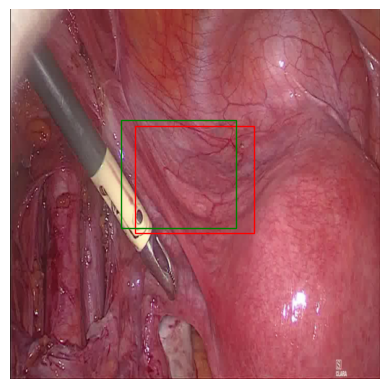

In [9]:
# Test the model on sample image
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from torchvision.transforms import functional
import numpy

# Load the image
image_path = "data/ART-Net/images/train/Train_Pos_sample_0001.png"
image = Image.open(image_path)

# Preprocess the image
image = functional.to_tensor(image)
image = functional.resize(image, (512, 512))
image = image.unsqueeze(0).to(device)

# Forward pass
model.eval()

with torch.no_grad():
    tool_preds, tool_conf, tooltip_preds, tooltip_conf = model(image)
    print(f"Tool predictions: {tool_preds}, Tool confidence: {tool_conf}")
    print(f"Tooltip predictions: {tooltip_preds}, Tooltip confidence: {tooltip_conf}")

    # Tool prediction
    tool_conf = torch.sigmoid(tool_conf)
    tool_preds = torch.sigmoid(tool_preds)
    tool_preds = tool_preds * tool_conf
    tool_preds = tool_preds.cpu().numpy()

    # Tooltip prediction
    tooltip_conf = torch.sigmoid(tooltip_conf)
    tooltip_preds = torch.sigmoid(tooltip_preds)
    tooltip_preds = tooltip_preds * tooltip_conf
    tooltip_preds = tooltip_preds.cpu().numpy()

    # Convert to numpy
    image = image.cpu().numpy().squeeze()
    image = numpy.moveaxis(image, 0, -1)
    image = numpy.clip(image, 0, 1)
    image = (image * 255).astype(numpy.uint8)

    # Take the normalised predictions and convert them to pixel coordinates for the image
    tool_preds = tool_preds.squeeze()
    tooltip_preds = tooltip_preds.squeeze()
    tool_preds = tool_preds * image.shape[0]
    tooltip_preds = tooltip_preds * image.shape[0]
    
    # Plot bounding boxes
    fig, ax = plt.subplots()
    plt.axis("off")
    ax.imshow(image)
    
    # Tool bounding box
    tool_x, tool_y, tool_w, tool_h = tool_preds
    tool_rect = matplotlib.patches.Rectangle(
        (tool_x, tool_y), tool_w, tool_h, edgecolor="r", facecolor="none"
    )
    
    # Tooltip bounding box
    tooltip_x, tooltip_y, tooltip_w, tooltip_h = tooltip_preds
    tooltip_rect = matplotlib.patches.Rectangle(
        (tooltip_x, tooltip_y), tooltip_w, tooltip_h, edgecolor="g", facecolor="none"
    )
    
    ax.add_patch(tool_rect)
    ax.add_patch(tooltip_rect)
    plt.show()

In [10]:
model.eval()

image_folder = "data/6DOF/Test 3"
# run tracking
images = []
for i in range(1, 10):
    image = cv2.imread(f"{image_folder}/{i}.bmp")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))  # Resize images to 512x512
    image = image / 255.0
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    images.append(image)

tracks = model.track_objects(images)
print(tracks)

# Use Matplotlib to show bounding boxes on the original images
for i, image in enumerate(images):
    image = image.squeeze(0).permute(1, 2, 0).numpy()
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    for box, conf in tracks[i]:
        x, y, w, h = box
        x, y, w, h = int(x), int(y), int(w), int(h)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv2.imshow("Image", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

[[(array([ 0.10101846, -0.03700255,  0.00895285, -0.21672349], dtype=float32), array([0.6047118], dtype=float32))], [(array([ 0.10124177, -0.03710567,  0.0091766 , -0.2169755 ], dtype=float32), array([0.6048366], dtype=float32))], [(array([ 0.10054091, -0.03662965,  0.00880097, -0.21574463], dtype=float32), array([0.6045363], dtype=float32))], [(array([ 0.10054091, -0.03662965,  0.00880097, -0.21574463], dtype=float32), array([0.6045363], dtype=float32))], [(array([ 0.09971479, -0.0362925 ,  0.0079059 , -0.2138909 ], dtype=float32), array([0.6042593], dtype=float32))], [(array([ 0.10033342, -0.03680342,  0.00822789, -0.21524969], dtype=float32), array([0.6041018], dtype=float32))], [(array([ 0.10018344, -0.03653961,  0.00812593, -0.2145511 ], dtype=float32), array([0.60403603], dtype=float32))], [(array([ 0.10005435, -0.03652795,  0.00815201, -0.21491632], dtype=float32), array([0.6035945], dtype=float32))], [(array([ 0.10005435, -0.03652795,  0.00815201, -0.21491632], dtype=float32), 

2024-07-31 21:02:02.601 Python[92369:2807762] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


: 